In [11]:
import sys
from os import path
sys.path.append( path.abspath('..') )

In [12]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from src.model.mask import get_mask_noise
from src.model.dataset import DefaultTransform
from src.model.model import Generator
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import os
import torch

In [1]:
%matplotlib inline

In [13]:
tf = DefaultTransform()
device = torch.device('cuda')

In [34]:
filepath = '../.mnt/scratch/data/train/p63/'

In [37]:
files = [file for file in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, file)) and file.endswith('.png')]

In [38]:
len(files)

61791

In [57]:
brown_images = []
blue_images = []
limit = 2000

In [58]:
for file in files:
    try:
        image = Image.open(os.path.join(filepath, file)).convert('RGB')
    except:
        continue
    
    image = tf(image)
    
    if ((image[1] + image[2]) / 2).mean() >= 0:
        if len(brown_images) < limit:
            brown_images.append(image.unsqueeze(0).to(device))
    else:
        if len(blue_images) < limit:
            blue_images.append(image.unsqueeze(0).to(device))
    
    if len(blue_images) >= limit and len(brown_images) >= limit:
        break

In [59]:
print(len(blue_images), len(brown_images))

2000 2000


In [43]:
model = torch.load('../.mnt/scratch/models/Experiment 15/model_checkpoint_25.pth')
gen = Generator(32, 8).to(device)
gen.load_state_dict(model['generator_he_to_p63_state_dict'])
gen.eval()

Generator(
  (conv1dc): ConvBlock(
    (conv): Conv2d(6, 3, kernel_size=(1, 1), stride=(1, 1))
    (bn): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (conv1dm): ConvBlock(
    (conv): Conv2d(6, 3, kernel_size=(1, 1), stride=(1, 1))
    (bn): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (interpretable_conv_1): ConvBlock(
    (conv): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
    (bn): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (interpretable_conv_2): ConvBlock(
    (conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (bn)

In [60]:
images = blue_images + brown_images

In [61]:
codes = []
with torch.no_grad():
    for image in images:
        mask = get_mask_noise(image).to(device)
        _ = gen(image, mask)
        code = gen.get_resnet_transformed()
        codes.append(code.detach().cpu().numpy())

In [62]:
codes = np.array(codes).squeeze()

In [63]:
codes_2d = codes.reshape(codes.shape[0], codes.shape[1] * codes.shape[2] * codes.shape[3])

In [64]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(codes_2d)

In [67]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, verbose=1)
tsne_results = tsne.fit_transform(pca_results)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.005s...
[t-SNE] Computed neighbors for 4000 samples in 0.070s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 28.335850
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.408939
[t-SNE] KL divergence after 1000 iterations: 0.651032


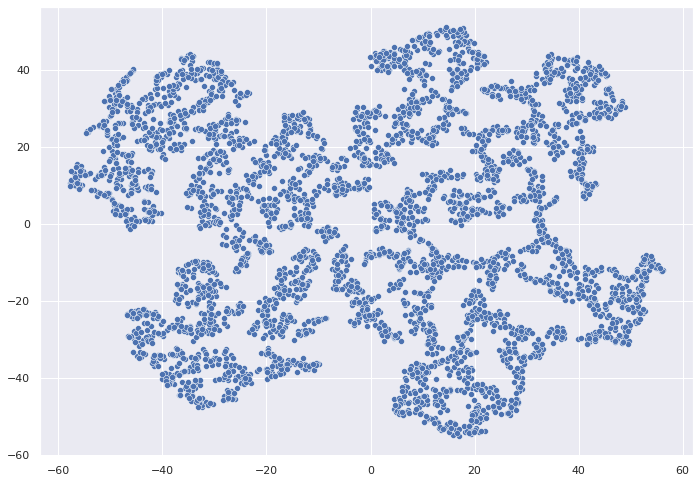

In [68]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    palette=palette
)
plt.show()

In [69]:
filepath = '../.mnt/scratch/data/train/he/'
files = [file for file in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, file)) and file.endswith('.png')]

In [71]:
images = []
limit = 4000

In [72]:
for file in files:
    try:
        image = Image.open(os.path.join(filepath, file)).convert('RGB')
    except:
        continue
    
    image = tf(image)
    
    images.append(image.unsqueeze(0).to(device))
    
    if len(images) >= limit:
        break

In [73]:
codes = []
with torch.no_grad():
    for image in images:
        mask = get_mask_noise(image).to(device)
        _ = gen(image, mask)
        code = gen.get_resnet_transformed()
        codes.append(code.detach().cpu().numpy())

In [74]:
codes = np.array(codes).squeeze()

In [75]:
codes_2d = codes.reshape(codes.shape[0], codes.shape[1] * codes.shape[2] * codes.shape[3])

In [76]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(codes_2d)

In [81]:
tsne = TSNE(n_components=2, perplexity=80, n_iter=1000, verbose=1)
tsne_results = tsne.fit_transform(pca_results)

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.005s...
[t-SNE] Computed neighbors for 4000 samples in 0.140s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 17.044145
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.167858
[t-SNE] KL divergence after 1000 iterations: 0.552226


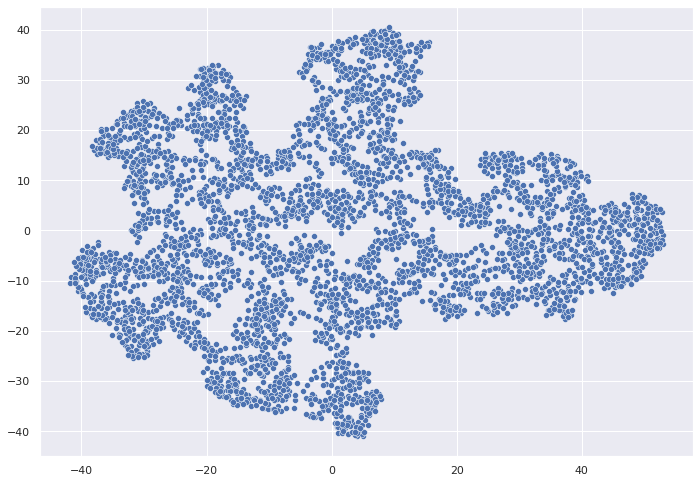

In [82]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    palette=palette
)
plt.show()